# Sweep Line Voronoi Diagram (Fortune's Algorithm)

The Voronoi diagram is a partitioning of a plane into regions based on the distance to a specific point. Given a set of points, the Voronoi diagram is the set of points in the plane that are equidistant to the input points. The Voronoi diagram is also known as a Dirichlet tessellation.

In dimension 2, a Voronoi diagram of $n\geq 3$ sites has at most $2n-5$ vertices and $3n-6$ edges. The Voronoi diagram can be constructed in $O(n\log n)$ time using Fortune's algorithm.

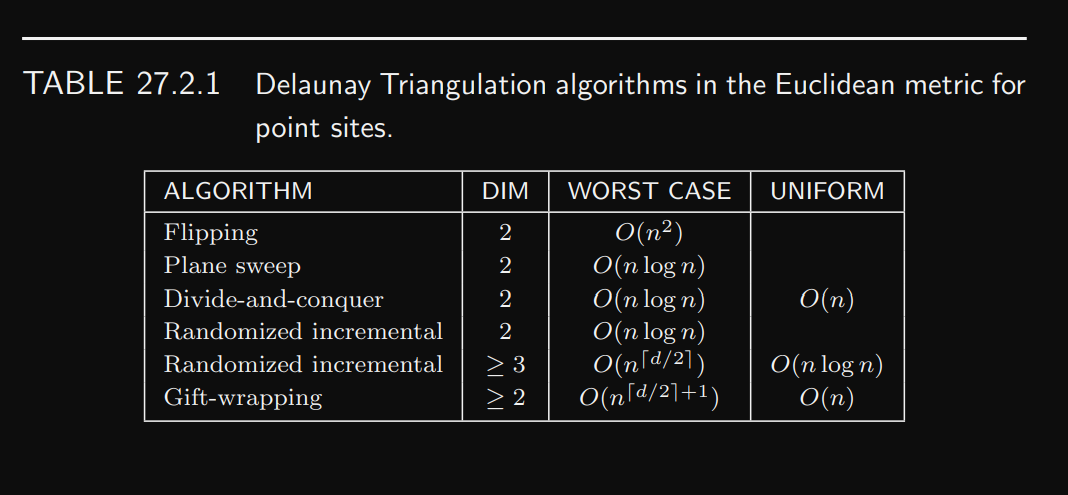

Reference:
- https://en.wikipedia.org/wiki/Fortune%27s_algorithm
- Handbook of DISCRETE AND COMPUTATIONAL GEOMETRY THIRD EDITION - Chapter 27 

In [1]:
import heapq
import random
from math import hypot
from typing import List, Tuple, TypeVar

# Define type aliases
ll = int
vi = List[int]
pii = Tuple[int, int]

# Define utility functions
def sz(x):
    return len(x)

def all(x):
    return x

# Define a helper function for the rep macro
def rep(start, end):
    return range(start, end)

T = TypeVar('T')

def minpq(items: List[T] = []):
    return heapq.heapify(items)

ftype = float
EPS = 1e-12
INF = 1e100

# Point class
class pt:
    def __init__(self, x: ftype = 0, y: ftype = 0):
        self.x = x
        self.y = y

    def __add__(self, o: 'pt') -> 'pt':
        return pt(self.x + o.x, self.y + o.y)

    def __sub__(self, o: 'pt') -> 'pt':
        return pt(self.x - o.x, self.y - o.y)

    def __mul__(self, f: ftype) -> 'pt':
        return pt(self.x * f, self.y * f)

    def rot(self) -> 'pt':
        return pt(-self.y, self.x)

    def dot(self, o: 'pt') -> ftype:
        return self.x * o.x + self.y * o.y

    def cross(self, o: 'pt') -> ftype:
        return self.x * o.y - self.y * o.x
    
    def gety(self) -> ftype:
        return self.y
    
    def len(self) -> ftype:
        return hypot(self.x, self.y)
    
    def __lt__(self, other):
        if self.y == other.y:
            return self.x < other.x
        return self.y < other.y
    
    def __eq__(self, other):
        return self.x == other.x and self.y == other.y
    
    def __hash__(self):
        return hash((self.x, self.y))
    
    def __repr__(self):
        return f"({self.x}, {self.y})"
    
# Utils functions for points
def collinear(a: pt, b: pt) -> bool:
    return abs(a.cross(b)) < EPS

def ccw(a: pt, b: pt, c: pt) -> bool:
    return (b - a).cross(c - a) > 0

def cw(a: pt, b: pt, c: pt) -> bool:
    return (b - a).cross(c - a) < 0

def lineline(a: pt, b: pt, c: pt, d: pt) -> pt:
    return a + (b - a) * ((c - a).cross(d - c) / (b - a).cross(d - c))

def circumcenter(a: pt, b: pt, c: pt) -> pt:
    b = (a + b) * 0.5;
    c = (a + c) * 0.5;
    return lineline(b, b + (b - a).rot(), c, c + (c - a).rot());

def circumcircle(a: pt, b: pt, c: pt) -> Tuple[pt, ftype]:
    center = circumcenter(a, b, c)
    return center, (a - center).len()

def generate_points(n,l=0,r=1000):
    points = set()
    for _ in range(n):
        points.add(pt(random.uniform(l,r), random.uniform(l,r)))
    return list(points)

(55.99100657671198, -369.31166583266645) 1028.0186690041098


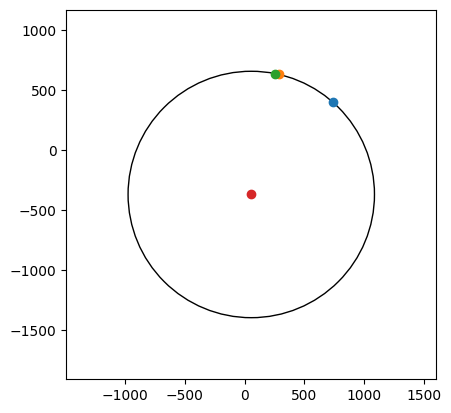

In [2]:
# Plot circumcircle
import matplotlib.pyplot as plt

points = generate_points(1000)

center, radius = circumcircle(points[1], points[3], points[2])
print(center, radius)
circle = plt.Circle((center.x, center.y), radius, fill=False)
fig, ax = plt.subplots()
ax.add_artist(circle)
ax.set_xlim(center.x - 1.5*radius, center.x + 1.5*radius)
ax.set_ylim(center.y - 1.5*radius, center.y + 1.5*radius)
for p in [points[1], points[3], points[2], center]:
    plt.scatter(p.x, p.y)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

## C++ implementation

In [3]:
from ctypes import *

# Load the shared library
lib = cdll.LoadLibrary('./voronoi.so')

# Define the function signature
# float* voronoiDiagramWrapper(float *xValues, float *yValues, int numValues, float minX, float maxX, float minY, float maxY, float minDistanceBetweenSites, GraphEdge **edges, int *numEdges)
lib.voronoiDiagramWrapper.argtypes = [POINTER(c_float), POINTER(c_float), c_int, c_float, c_float, c_float, c_float, c_float, POINTER(POINTER(c_void_p)), POINTER(c_int)]
lib.voronoiDiagramWrapper.restype = POINTER(c_float)

Generating Voronoi diagram from C++!


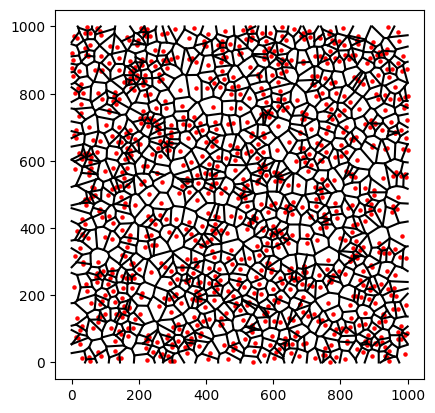

In [4]:
# Convert the points to a flat array
xValues = (c_float * len(points))()
yValues = (c_float * len(points))()

for i, p in enumerate(points):
    xValues[i] = p.x
    yValues[i] = p.y

# Call the function
edges = POINTER(c_void_p)()
numEdges = c_int(0)
result = lib.voronoiDiagramWrapper(xValues, yValues, len(points), 0, 1000, 0, 1000, 0, byref(edges), byref(numEdges))

# Extract the edges
n = int(result[0])
edges = []
for i in range(1, n * 4, 4):
    a = result[i]
    b = result[i + 1]
    c = result[i + 2]
    d = result[i + 3]
    edges.append((a, b, c, d))

# Plot the Voronoi diagram
for a, b, c, d in edges:
    plt.plot([a, c], [b, d], 'k-')

for p in points:
    plt.scatter(p.x, p.y, c='r', s=5)

plt.gca().set_aspect('equal', adjustable='box')
plt.show()


## Python implementation


### Priority Queue

In [5]:
'''
Created on Apr 18, 2012

@author: mikko
'''
import heapq
import itertools

class PriorityQueue(object):
    '''
    Creates Priority queue to use with Fortunes's algorithm
    item is a tuple of ((x,y), pointer_to_leaf)
    '''

    def __init__(self, items=[]):
        '''
        Constructor
        '''
        self.heap = []
        self.entries = {}
        self.counter = itertools.count(0,-1)
        for i in items:
            self.add(i)

    def add(self, item):
        # Check for duplicate
        if item[0] in self.entries:
            return

        count = next(self.counter)
        # use negative y-coordinate as a primary key
        # heapq in python is min-heap and we need max-heap
        entry = [item[0][1]*-1, count, item]
        self.entries[item[0]] = entry
        heapq.heappush(self.heap, entry)

    def pop(self):
        while self.heap:
            temp = heapq.heappop(self.heap)
            if not temp[2] == 'DELETED':
                del self.entries[temp[2][0]]
                return temp[2]
        raise KeyError('pop from an empty priority queue')

    def delete(self, item):
        entry = self.entries.pop(item[0])
        entry[2] = 'DELETED'


### DCEL

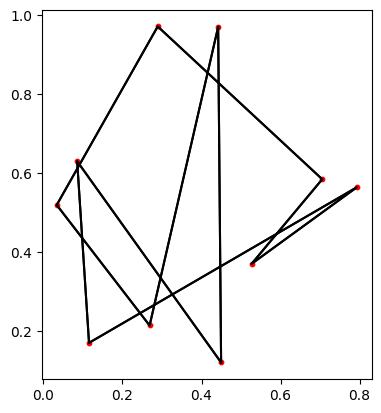

In [6]:
#!/usr/bin/env python
#Copyright 2008, Angel Yanguas-Gil

__all__ = ['Dcel', 'Vertex', 'Hedge', 'Face']

#from xygraph import Xygraph

import math as m

class DcelError(Exception): pass

class Vertex:
    """Minimal implementation of a vertex of a 2D dcel"""

    def __init__(self, px, py):
        self.x = px
        self.y = py
        self.IncidentEdge = None
        self.hedgelist = []

    def sortincident(self):
        self.hedgelist.sort(reverse=True)


class Hedge:
    """Minimal implementation of a half-edge of a 2D dcel"""

    def __init__(self,v1=None,v2=None):
        #The origin is defined as the vertex it points to
        self.origin = v2
        self.twin = None
        self.face = None
        self.nexthedge = None
        try:
            self.angle = hangle(v2.x-v1.x, v2.y-v1.y)
        except:
            self.angle = 0
        self.prevhedge = None
        try:
            self.length = m.sqrt((v2.x-v1.x)**2 + (v2.y-v1.y)**2)
        except:
            self.length = 0

    def __lt__(self, other):
        return self.angle < other.angle


class Face:
    """Implements a face of a 2D dcel"""

    def __init__(self):
        self.wedge = None
        self.data = None
        self.external = None

    def area(self):
        h = self.wedge
        a = 0
        while(not h.nexthedge is self.wedge):
            p1 = h.origin
            p2 = h.nexthedge.origin
            a += p1.x*p2.y - p2.x*p1.y
            h = h.nexthedge

        p1 = h.origin
        p2 = self.wedge.origin
        a = (a + p1.x*p2.y - p2.x*p1.y)/2
        return a

    def perimeter(self):
        h = self.wedge
        p = 0
        while (not h.nexthedge is self.wedge):
            p += h.length
            h = h.nexthedge
        return p

    def vertexlist(self):
        h = self.wedge
        pl = [h.origin]
        while(not h.nexthedge is self.wedge):
            h = h.nexthedge
            pl.append(h.origin)
        return pl

    def isinside(self, p):
        """Determines whether a point is inside a face"""

        h = self.wedge
        inside = False
        if lefton(h, p):
            while(not h.nexthedge is self.wedge):
                h = h.nexthedge
                if not lefton(h, p):
                    return False
            return True
        else:
            return False


class Dcel():
    """
    Implements a doubly-connected edge list
    """

    def __init__(self, vl=[], el=[], clip=None):
        self.vertices = []
        self.vl = vl
        self.hedges = []
        self.el = el
        self.faces = []
        if vl != []:
            if clip is not None:
                self.clip(clip)
            self.build_dcel()


    def build_dcel(self):
        """
        Creates the dcel from the list of vertices and edges
        """

#Step 1: vertex list creation
        for v in self.vl:
            self.vertices.append(Vertex(v[0], v[1]))

#Step 2: hedge list creation. Assignment of twins and
#vertices
        for e in self.el:
            if e[0] >= 0 and e[1] >= 0:
                h1 = Hedge(self.vertices[e[0]], self.vertices[e[1]])
                h2 = Hedge(self.vertices[e[1]], self.vertices[e[0]])
                h1.twin = h2
                h2.twin = h1
                self.vertices[e[1]].hedgelist.append(h1)
                self.vertices[e[0]].hedgelist.append(h2)
                self.hedges.append(h2)
                self.hedges.append(h1)

        #Step 3: Identification of next and prev hedges
        for v in self.vertices:
            v.sortincident()
            l = len(v.hedgelist)
            if l < 2:
                raise DcelError(
                    "Badly formed dcel: less than two hedges in vertex")
            else:
                for i in range(l-1):
                    v.hedgelist[i].nexthedge = v.hedgelist[i+1].twin
                    v.hedgelist[i+1].prevhedge = v.hedgelist[i]
                v.hedgelist[l-1].nexthedge = v.hedgelist[0].twin
                v.hedgelist[0].prevhedge = v.hedgelist[l-1]

        #Step 4: Face assignment
        provlist = self.hedges[:]
        nf = 0
        nh = len(self.hedges)

        while nh > 0:
            h = provlist.pop()
            nh -= 1
            #We check if the hedge already points to a face
            if h.face == None:
                f = Face()
                nf += 1
                #We link the hedge to the new face
                f.wedge = h
                f.wedge.face = f
                #And we traverse the boundary of the new face
                while (not h.nexthedge is f.wedge):
                    h = h.nexthedge
                    h.face = f
                self.faces.append(f)
        #And finally we have to determine the external face
        for f in self.faces:
            f.external = f.area() < 0


    def findpoints(self, pl, onetoone=False):
        """Given a list of points pl, returns a list of
        with the corresponding face each point belongs to and
        None if it is outside the map.

        """

        ans = []
        if onetoone:
            fl = self.faces[:]
            for p in pl:
                found = False
                for f in fl:
                    if f.external:
                        continue
                    if f.isinside(p):
                        fl.remove(f)
                        found = True
                        ans.append(f)
                        break
                if not found:
                    ans.append(None)

        else:
            for p in pl:
                found = False
                for f in self.faces:
                    if f.external:
                        continue
                    if f.isinside(p):
                        found = True
                        ans.append(f)
                        break
                if not found:
                    ans.append(None)

        return ans

    def areas(self):
        return [f.area() for f in self.faces if not f.external]

    def perimeters(self):
        return [f.perimeter() for f in self.faces if not f.external]

    def nfaces(self):
        return len(self.faces)

    def nvertices(self):
        return len(self.vertices)

    def nedges(self):
        return len(self.hedges)/2

    def minmax(self):
        """Determines the boundary box of the vertices in the graph"""
        vx = [v[0] for v in self.vl]
        vy = [v[1] for v in self.vl]
        self.xmax, self.xmin = max(vx), min(vx)
        self.ymax, self.ymin = max(vy), min(vy)


#Misc. functions


def hsort(h1, h2):
    """Sorts two half edges counterclockwise"""

    if h1.angle < h2.angle:
        return -1
    elif h1.angle > h2.angle:
        return 1
    else:
        return 0


def checkhedges(hl):
    """Consistency check of a hedge list: nexthedge, prevhedge"""

    for h in hl:
        if h.nexthedge not in hl or h.prevhedge not in hl:
            raise DcelError("Problems with an orphan hedge...")


def area2(hedge, point):
    """Determines the area of the triangle formed by a hedge and
    an external point"""

    pa = hedge.twin.origin
    pb=hedge.origin
    pc=point
    return (pb.x - pa.x)*(pc[1] - pa.y) - (pc[0] - pa.x)*(pb.y - pa.y)


def lefton(hedge, point):
    """Determines if a point is to the left of a hedge"""

    return area2(hedge, point) >= 0


def hangle(dx,dy):
    """Determines the angle with respect to the x axis of a segment
    of coordinates dx and dy
    """

    l = m.sqrt(dx*dx + dy*dy)
    if dy > 0:
        return m.acos(dx/l)
    else:
        return 2*m.pi - m.acos(dx/l)


if __name__=='__main__':
    # Random example
    import random
    vl = [(random.random(), random.random()) for i in range(10)]
    el = [(i, (i+1)%10) for i in range(10)] 
    d = Dcel(vl, el)

    # Plot the DCEL
    import matplotlib.pyplot as plt

    for f in d.faces:
        pl = f.vertexlist()
        pl.append(pl[0])
        plt.plot([v.x for v in pl], [v.y for v in pl], 'k-')

    for v in d.vertices:
        plt.scatter(v.x, v.y, c='r', s=10)

    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()



### Binary Search Tree

In [7]:
## {{{ http://code.activestate.com/recipes/577540/ (r2)
"""
Binary Search Tree: A sorted collection of values that supports
efficient insertion, deletion, and minimum/maximum value finding.
"""
# Copyright (C) 2008 by Edward Loper
#
# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
# THE SOFTWARE.

# Modified by Mikko Johansson "(2012) to use with Fortunes's algorithm

# IMPLEMENTATION NOTES:
#
# Internally, we represent tree nodes using Python lists.  These lists
# may either be empty (for empty nodes) or may have length four (for
# non-empty nodes).  The non-empty nodes contain:
#
#     [left_child, right_child, value, sort_key]
#
# Using lists rather than a node class more than doubles the overall
# performance in the benchmarks that I have run.
#
# The sort key is always accessed as node[-1].  This allows us to
# optimize the case where the sort key is identical to the value, by
# encoding such nodes as simply:
#
#     [left_child, right_child, value]
#
# The following constants are used to access the pieces of each search
# node.  If the constant-binding optimization recipe (which can be
# downloaded from <http://code.activestate.com/recipes/277940/>) is
# available, then it is used to replace these constants at
# import-time, increasing the binary search tree efficiency by 3-5%.
import math

_LEFT = 0
_RIGHT = 1
_PARENT = 2
_VALUE = 3
_SORT_KEY = -1

class BinarySearchTree(object):
    """
    A sorted collection of values that supports efficient insertion,
    deletion, and minimum/maximum value finding.  Values may sorted
    either based on their own value, or based on a key value whose
    value is computed by a key function (specified as an argument to
    the constructor).

    BinarySearchTree allows duplicates -- i.e., a BinarySearchTree may
    contain multiple values that are equal to one another (or multiple
    values with the same key).  The ordering of equal values, or
    values with equal keys, is undefined.
    """
    def __init__(self):
        """
        Create a new empty BST.  If a sort key is specified, then it
        will be used to define the sort order for the BST.  If an
        explicit sort key is not specified, then each value is
        considered its own sort key.
        """
        self._root = [] # = empty node
        self._sort_key = self._get_breakpoint
        self._len = 0 # keep track of how many items we contain.

    #/////////////////////////////////////////////////////////////////
    # Public Methods
    #/////////////////////////////////////////////////////////////////

    def insert(self, item, pq, edge_list):
        """
        Insert the specified item into the BST.
        """
        # print ("insert")
        new_value = {'point': item, 'break_point': None, 'pointer': None}
        
        site_x = new_value['point'][0]
        site_y = new_value['point'][1]
        
        # Walk down the tree until we find an empty node.
        node = self._root
        traversed = []
        while node and node[_VALUE]['break_point'] is not None:
            
            traversed.append(node)

            if site_x < node[_SORT_KEY](node[_VALUE], site_y):
                # print("left: "),
                # print (site_x < node[_SORT_KEY](node[_VALUE], site_y))
                node = node[_LEFT]
            else:
                # print("rightright")
                node = node[_RIGHT]
        #split the node
        if node == []:
            # print ("root")
            node[:] = [[], [], None, new_value, self._sort_key]
            return
        else:
            traversed.append(node)

        #delete circle event from queue
        if node[_VALUE]['pointer'] is not None:
            pq.delete(node[_VALUE]['pointer'])
            node[_VALUE]['pointer'] = None
        
        left_value = node[_VALUE]
        hedge1 = Hedge()
        hedge2 = Hedge()
        hedge1.twin = hedge2
        hedge2.twin = hedge1
        edge_list.hedges.append(hedge1)
        edge_list.hedges.append(hedge2)
        
        node[_VALUE] = {'point': None, 'break_point' : (left_value['point'], item), 'hedge': hedge1}
        parent = node
        node = node[_LEFT]
        node[:] = [[], [], parent, left_value, self._sort_key]

        # Save node for circle event check
        left1 = left_value['point']
        left_node = node

        node = parent[_RIGHT]
        node[:] = [[], [], parent, {'point': None, 'break_point' : (item, left_value['point']), 'hedge': hedge2}, self._sort_key]
        parent = node

        node = node[_LEFT]
        node[:] = [[], [], parent, new_value, self._sort_key]
        # Save node for circle event check
        new_node = node
        node = parent[_RIGHT]
        node[:] = [[], [], parent, left_value, self._sort_key]
        # Save node for circle event check
        right1 = left1
        right_node = node

        # Check for new circle events
        # there has to be a better way to find the triplet
        traversed_right = traversed[:]
        # find the leftmost arc of the triplet
        #print traversed
        n = traversed.pop()
        
        while traversed and n[_VALUE]['break_point'][0] == left1:
            n = traversed.pop()

        if traversed:
            left2 = n[_VALUE]['break_point'][0]
            circle_event = self._get_circle_event(left2, left1, new_node[_VALUE]['point'], site_y)
            if circle_event is not None:
                circle_event_site = (circle_event[0], (left_node))
                left_node[_VALUE]['radius'] = circle_event[1]
                left_node[_VALUE]['pointer'] = circle_event_site
                pq.add(circle_event_site)

        # find the rightmost arc of the triplet
        n = traversed_right.pop()
        # Get rid of the original splitted node
        if traversed_right:
            n = traversed_right.pop()
        while traversed_right and n[_VALUE]['break_point'][1] == right1:
            n = traversed_right.pop()

        if True:
            right2 = n[_VALUE]['break_point'][1]
            circle_event = self._get_circle_event(new_node[_VALUE]['point'], right1, right2, site_y)
            if circle_event is not None:
                circle_event_site = (circle_event[0], right_node)
                right_node[_VALUE]['radius'] = circle_event[1]
                right_node[_VALUE]['pointer'] = circle_event_site
                pq.add(circle_event_site)

    def pred(self, node):
        site = node[_VALUE]['point']
        while node[_PARENT][_VALUE]['break_point'][0] == site:
            node = node[_PARENT]
        
        node = node[_PARENT][_LEFT]
        while node[_VALUE]['break_point'] is not None:
            node = node[_RIGHT]

        return node

    def succ(self, node):
        site = node[_VALUE]['point']
        while node[_PARENT][_VALUE]['break_point'][1] == site:
            node = node[_PARENT]
        node = node[_PARENT][_RIGHT]
        while node[_VALUE]['break_point'] is not None:
            node = node[_LEFT]
            
        return node

    def minimum(self):
        """
        Return the value with the minimum sort key.  If multiple
        values have the same (minimum) sort key, then it is undefined
        which one will be returned.
        """
        return self._extreme_node(_LEFT)[_VALUE]

    def maximum(self):
        """
        Return the value with the maximum sort key.  If multiple values
        have the same (maximum) sort key, then it is undefined which one
        will be returned.
        """
        return self._extreme_node(_RIGHT)[_VALUE]

    def find(self, sort_key):
        """
        Find a value with the given sort key, and return it.  If no such
        value is found, then raise a KeyError.
        """
        return self._find(sort_key)[_VALUE]

    def pop_min(self):
        """
        Return the value with the minimum sort key, and remove that value
        from the BST.  If multiple values have the same (minimum) sort key,
        then it is undefined which one will be returned.
        """
        return self._pop_node(self._extreme_node(_LEFT))

    def pop_max(self):
        """
        Return the value with the maximum sort key, and remove that value
        from the BST.  If multiple values have the same (maximum) sort key,
        then it is undefined which one will be returned.
        """
        return self._pop_node(self._extreme_node(_RIGHT))

    def pop(self, sort_key):
        """
        Find a value with the given sort key, remove it from the BST, and
        return it.  If multiple values have the same sort key, then it is
        undefined which one will be returned.  If no value has the
        specified sort key, then raise a KeyError.
        """
        return self._pop_node(self._find(sort_key))

    def values(self, reverse=False):
        """Generate the values in this BST in sorted order."""
        if reverse:
            return self._iter(_RIGHT, _LEFT)
        else:
            return self._iter(_LEFT, _RIGHT)
    __iter__ = values

    def __len__(self):
        """Return the number of items in this BST"""
        return self._len

    def __nonzero__(self):
        """Return true if this BST is not empty"""
        return self._len>0

    def __repr__(self):
        return '<BST: (%s)>' % ', '.join('%r' % v for v in self)

    def __str__(self):
        return self.pprint()

    def pprint(self, max_depth=10, frame=True, show_key=True):
        """
        Return a pretty-printed string representation of this binary
        search tree.
        """
        t,m,b = self._pprint(self._root, max_depth, show_key)
        lines = t+[m]+b
        if frame:
            width = max(40, max(len(line) for line in lines))
            s = '+-'+'MIN'.rjust(width, '-')+'-+\n'
            s += ''.join('| %s |\n' % line.ljust(width) for line in lines)
            s += '+-'+'MAX'.rjust(width, '-')+'-+\n'
            return s
        else:
            return '\n'.join(lines)

    #/////////////////////////////////////////////////////////////////
    # Private Helper Methods
    #/////////////////////////////////////////////////////////////////

    def _extreme_node(self, side):
        """
        Return the leaf node found by descending the given side of the
        BST (either _LEFT or _RIGHT).
        """
        if not self._root:
            raise IndexError('Empty Binary Search Tree!')
        node = self._root
        # Walk down the specified side of the tree.
        while node[side]:
            node = node[side]
        return node

    def _find(self, sort_key):
        """
        Return a node with the given sort key, or raise KeyError if not found.
        """
        node = self._root
        while node:
            node_key = node[_SORT_KEY]
            if sort_key < node_key:
                node = node[_LEFT]
            elif sort_key > node_key:
                node = node[_RIGHT]
            else:
                return node
        raise KeyError("Key %r not found in BST" % sort_key)

    def _pop_node(self, node):
        """
        Delete the given node, and return its value.
        """
        value = node[_VALUE]
        if node[_LEFT]:
            if node[_RIGHT]:
                # This node has a left child and a right child; find
                # the node's successor, and replace the node's value
                # with its successor's value.  Then replace the
                # sucessor with its right child (the sucessor is
                # guaranteed not to have a left child).  Note: node
                # and successor may not be the same length (3 vs 4)
                # because of the key-equal-to-value optimization; so
                # we have to be a little careful here.
                successor = node[_RIGHT]
                while successor[_LEFT]: successor = successor[_LEFT]
                node[2:] = successor[2:] # copy value & key
                successor[:] = successor[_RIGHT]
            else:
                # This node has a left child only; replace it with
                # that child.
                node[:] = node[_LEFT]
        else:
            if node[_RIGHT]:
                # This node has a right child only; replace it with
                # that child.
                node[:] = node[_RIGHT]
            else:
                # This node has no children; make it empty.
                del node[:]
        self._len -= 1
        return value

    def _iter(self, pre, post):
        # Helper for sorted iterators.
        #   - If (pre,post) = (_LEFT,_RIGHT), then this will generate items
        #     in sorted order.
        #   - If (pre,post) = (_RIGHT,_LEFT), then this will generate items
        #     in reverse-sorted order.
        # We use an iterative implemenation (rather than the recursive one)
        # for efficiency.
        stack = []
        node = self._root
        while stack or node:
            if node: # descending the tree
                stack.append(node)
                node = node[pre]
            else: # ascending the tree
                node = stack.pop()
                yield node[_VALUE]
                node = node[post]

    def _pprint(self, node, max_depth, show_key, spacer=2):
        """
        Returns a (top_lines, mid_line, bot_lines) tuple,
        """
        if max_depth == 0:
            return ([], '- ...', [])
        elif not node:
            return ([], '- EMPTY', [])
        else:
            top_lines = []
            bot_lines = []
            mid_line = '-%r' % node[_VALUE]
            if len(node) > 3: mid_line += ' (key=%r)' % node[_SORT_KEY]
            if node[_LEFT]:
                t,m,b = self._pprint(node[_LEFT], max_depth-1,
                                     show_key, spacer)
                indent = ' '*(len(b)+spacer)
                top_lines += [indent+' '+line for line in t]
                top_lines.append(indent+'/'+m)
                top_lines += [' '*(len(b)-i+spacer-1)+'/'+' '*(i+1)+line
                              for (i, line) in enumerate(b)]
            if node[_RIGHT]:
                t,m,b = self._pprint(node[_RIGHT], max_depth-1,
                                     show_key, spacer)
                indent = ' '*(len(t)+spacer)
                bot_lines += [' '*(i+spacer)+'\\'+' '*(len(t)-i)+line
                              for (i, line) in enumerate(t)]
                bot_lines.append(indent+'\\'+m)
                bot_lines += [indent+' '+line for line in b]
            return (top_lines, mid_line, bot_lines)

    def _get_breakpoint(self, inner_node, yl):
        x1 = inner_node['break_point'][0][0]
        y1 = inner_node['break_point'][0][1]
        x2 = inner_node['break_point'][1][0]
        y2 = inner_node['break_point'][1][1]

        # check if y coordinates are equal, then breakpoint in the middle
        if y1 == y2:
            return (x1+x2)/2.0

        a = (y2-y1)/2.0
        b = ((x2)*(y1-yl)) - ((x1)*(y2-yl))
        c = ((y1*y1*y2)-(y2*yl*yl)-(y1*y1*yl)-(y2*y2*y1)+(y1*yl*yl)+(y2*y2*yl)+(y2*x1*x1)-(yl*x1*x1)-(y1*x2*x2)+(yl*x2*x2))/2.0

        determinant = b*b - 4 *a*c
        if determinant < 0:
            return 0
        bp1 = (-b + math.sqrt(determinant))/(2*a)
        bp2 = (-b - math.sqrt(determinant))/(2*a)

        if y1 < y2:
            return max(bp1, bp2)
        else:
            return min(bp1,bp2)

    #Calculate possible circle event, if found return lowest point else None
    def _get_circle_event(self, site1, site2, site3, ly):
        x1 = site1[0]
        y1 = site1[1]
        x2 = site2[0]
        y2 = site2[1]
        x3 = site3[0]
        y3 = site3[1]
        if x1 == x2 and x2 == x3:
            return None
        if y1 == y2 and y2 == y3:
            return None
        a = x2*x2 - x1*x1 + y2*y2 - y1*y1
        b = x3*x3 - x2*x2 + y3*y3 - y2*y2
        dx1 = x1 - x2
        dx2 = x3 - x2
        dy1 = y2 - y1
        dy2 = y3 - y2

        k = (a + ((2*dx1*b)/(2*dx2))) * (1/(2*dy1) - ((2*dx2)/(4*dx1*dy2)))
        h = (b + 2*dy2*k)/(2*dx2)
        r = math.sqrt((math.pow(x1-h, 2) + math.pow(y1-k, 2)))
        
        # Check converge (www.mail-archive.com/algogeeks@googlegroups.com/msg02478.html)
        if ((x2-x1)*(y3-y1)) - ((x3-x1)*(y2-y1)) > 0 and ly > h-r:
            return ((k, h-r), r)
        else:
            return None
        
if __name__ == '__main__':
    # Random example
    import random
    bst = BinarySearchTree()
    pq = PriorityQueue()
    edge_list = Dcel()
    for i in range(3):
        bst.insert((random.random(), random.random()), pq, edge_list)
    
    print(bst.minimum())
    print(bst.maximum())
    

{'point': (0.2794364596047304, 0.9868182515612715), 'break_point': None, 'pointer': None}
{'point': (0.2794364596047304, 0.9868182515612715), 'break_point': None, 'pointer': None}


### Voronoi Diagram

In [8]:
'''
Created on Apr 18, 2012

@author: Mikko Johansson
'''
import json
import codecs

sites = {}
edge_list = Dcel()
beach_line = BinarySearchTree()

def parse_input(infile):
    infilep = codecs.open(infile, 'r', 'utf-8')
    geoJson = json.load(infilep)
    infilep.close()
    features = geoJson['features']

    pointArray = []
    for f in features:
        x = f['geometry']['coordinates'][0]
        y = f['geometry']['coordinates'][1]
        pointArray.append(((x,y), None))

    return pointArray

def handle_site(site):
    # insert new site to the beachline
    beach_line.insert(site, sites, edge_list)

def handle_circle(site):
    print ("handle_circle: ")
    point = site[0]
    node = site[1]
    print(point)
    print(node[_VALUE]['break_point'])
    print(node[_VALUE]['point'])
    #remove possible circle events involving this site
    predecessor = beach_line.pred(node)
    successor = beach_line.succ(node)
    print("pre")
    print(predecessor[_VALUE]['point'])
    print(predecessor[_PARENT][_VALUE]['break_point'])
    print("endpre")
    print(successor[_VALUE]['point'])

    if predecessor[_VALUE]['pointer'] is not None:
        print("not None")
        #print(predecessor[_VALUE]['pointer'])
        sites.delete(predecessor[_VALUE]['pointer'])
        predecessor[_VALUE]['pointer'] = None
        print(predecessor[_PARENT][_VALUE]['break_point'])

    if successor[_VALUE]['pointer'] is not None:
        sites.delete(successor[_VALUE]['pointer'])
        successor[_VALUE]['pointer'] = None

    r = node[_VALUE]['radius']
    #Add breakpoint to the vertex list
    ver = Vertex(point[0], point[1] - r)
    edge_list.vertices.append(ver)
    #Update beach_line and add pointers to hedges to new vertex
    parent = node[_PARENT]
    site = node[_VALUE]['point']
    del node[:]

    new_hedge1 = Hedge()
    new_hedge2 = Hedge()
    new_hedge1.origin = ver
    ver.hedgelist.append(new_hedge1)
    new_hedge1.twin = new_hedge2
    new_hedge2.twin = new_hedge1
    edge_list.hedges.append(new_hedge1)
    edge_list.hedges.append(new_hedge2)

    right_hedge = parent[_VALUE]['hedge']
    left_hedge = parent[_PARENT][_VALUE]['hedge']

    if right_hedge.origin is None:
        right_hedge.origin = ver
        ver.hedgelist.append(right_hedge)
    else:
        right_hedge.twin.orig = ver
        ver.hedgelist.append(right_hedge.twin)

    if left_hedge.origin is None:
        left_hedge.origin = ver
        ver.hedgelist.append(left_hedge)
    else:
        left_hedge.twin.orig = ver
        ver.hedgelist.append(left_hedge.twin)

    #We always delete the parent
    node = parent
    parent = node[_PARENT]
    print("before delete" + str(predecessor[_PARENT][_VALUE]['break_point']))
    #Deleted leaf was left child
    if node[_RIGHT]:
        new_right = node[_VALUE]['break_point'][1]
        node[:] = node[_RIGHT]
        node[_PARENT] = parent
        print("was right" + str(predecessor[_PARENT][_VALUE]['break_point']))
        while parent[_VALUE]['break_point'][1] != site:
            parent = parent[_PARENT]
        bp_left = parent[_VALUE]['break_point'][0]
        parent[_VALUE]['break_point'] = (bp_left, new_right)
    else:
        new_left = node[_VALUE]['break_point'][0]
        print("was left" + str(predecessor[_PARENT][_VALUE]['break_point']))
        node[:] = node[_LEFT]
        print("was left" + str(parent[_VALUE]['break_point']))
        print("was left" + str(node[_VALUE]['point']))
        print("was left" + str(node[_PARENT][_VALUE]['point']))
        print("was left" + str(predecessor[_PARENT][_VALUE]['break_point']))
        node[_PARENT] = parent
        predecessor[_PARENT] = parent
        print("was left" + str(node[_PARENT][_VALUE]['break_point']))
        print("was left" + str(predecessor[_PARENT][_VALUE]['break_point']))
        # skip original grandparent
        parent = parent[_PARENT]
        while parent[_VALUE]['break_point'][0] != site:
            parent = parent[_PARENT]
        bp_right = parent[_VALUE]['break_point'][1]
        parent[_VALUE]['break_point'] = (new_left, bp_right)

    #link new hedge to node
    parent[_VALUE]['hedge'] = new_hedge1

    # check new arc triples
    # Former left in the middle
    print("left1" + str(predecessor[_PARENT][_VALUE]['break_point']))

    left1 = beach_line.pred(predecessor)
    right1 = beach_line.succ(predecessor)
    circle_event = beach_line._get_circle_event(left1[_VALUE]['point'],
                                                predecessor[_VALUE]['point'],
                                                right1[_VALUE]['point'],
                                                site[1])
    if circle_event is not None:
        circle_event_site = (circle_event[0], predecessor)
        predecessor[_VALUE]['radius'] = circle_event[1]
        #print(type(circle_event_site))
        predecessor[_VALUE]['pointer'] = circle_event_site
        sites.add(circle_event_site)

    # Former right in the middle
    left2 = beach_line.pred(successor)
    right2 = beach_line.succ(successor)
    circle_event = beach_line._get_circle_event(left2[_VALUE]['point'],
                                                successor[_VALUE]['point'],
                                                right2[_VALUE]['point'],
                                                site[1])
    if circle_event is not None:
        circle_event_site = (circle_event[0], successor)
        successor[_VALUE]['radius'] = circle_event[1]
        #print(type(circle_event_site))
        successor[_VALUE]['pointer'] = circle_event_site
        sites.add(circle_event_site)

if __name__ == '__main__':
    pointList = []
    #import random

    #for a in range(0,200):
    #    pointList.append(((random.randint(0,1000), random.randint(0,1000)), None))

    pointList.append(((8,12), None))
    pointList.append(((16,9), None))
    pointList.append(((3,5), None))
    pointList.append(((6,1), None))
    sites = PriorityQueue(pointList[:200])



    #Test
    counter = 1
    # Go through sites
#    while sites and counter < 20:
    while sites:
#        try:
        s = sites.pop()
        #Check if site event
        if s[1] == None:
            #print (s)
            handle_site(s[0])
        else:
#            node = s[1]
#            print("len_node: " + str(len(node)))
            handle_circle(s)
#        except KeyError as err:
#            print ("error")
#            print err
#            break

        #Test
        if s[1] is None:
            print ("SiteEvent: "),
        else:
            print("CircleEvent: "),
        print (str(counter) + ": x: " + str(s[0][0]) + ": y: " + str(s[0][1]))
        counter += 1


SiteEvent: 
1: x: 8: y: 12
SiteEvent: 
2: x: 16: y: 9
SiteEvent: 
3: x: 3: y: 5
SiteEvent: 
4: x: 6: y: 1
handle_circle: 
(-0.6035714285714288, -12.966756091128703)
None
(3, 5)
pre
(8, 12)
((8, 12), (3, 5))
endpre
(6, 1)
before delete((8, 12), (3, 5))
was right((8, 12), (3, 5))
left1((8, 12), (6, 1))


TypeError: 'NoneType' object is not subscriptable